In [188]:
# For Reading Data
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import missingno as msno

# style
plt.style.use("fivethirtyeight")
sns.set_style("darkgrid")

# Model creation and algorithm implementation
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score

# Model evaluation
import statsmodels.api as sm
from sklearn import metrics

# Ignoring warnings
import warnings
warnings.filterwarnings('ignore')

## Problem Statement 

One of the largest retail chains in the world wants to use their vast data source to build an efficient forecasting model to predict the sales for each SKU in its portfolio at its 76 different stores using historical sales data for the past 3 years on a week-on-week basis. Sales and promotional information is also available for each week - product and store wise. 

However, no other information regarding stores and products are available. So we need to forecast accurately the sales values for every such product/SKU-store combination for the next 12 weeks accurately.

In [189]:
# Reading train & test datasets and visualising top 5 rows
train = pd.read_csv("train_0irEZ2H.csv")
test = pd.read_csv("test_nfaJ3J5.csv")
display(train.head())
display(test.head())

,record_ID,week,store_id,sku_id,total_price,base_price,is_featured_sku,is_display_sku,units_sold
0,1,17/01/11,8091,216418,99.0375,111.8625,0,0,20
1,2,17/01/11,8091,216419,99.0375,99.0375,0,0,28
2,3,17/01/11,8091,216425,133.9500,133.9500,0,0,19
3,4,17/01/11,8091,216233,133.9500,133.9500,0,0,44
4,5,17/01/11,8091,217390,141.0750,141.0750,0,0,52


,record_ID,week,store_id,sku_id,total_price,base_price,is_featured_sku,is_display_sku
0,212645,16/07/13,8091,216418,108.3000,108.3000,0,0
1,212646,16/07/13,8091,216419,109.0125,109.0125,0,0
2,212647,16/07/13,8091,216425,133.9500,133.9500,0,0
3,212648,16/07/13,8091,216233,133.9500,133.9500,0,0
4,212649,16/07/13,8091,217390,176.7000,176.7000,0,0


## Data Description

### Variable | Definition

###### record_ID           | Unique ID for each week store sku combination 
###### week                   | Starting Date of the week
###### store_id            | Unique ID for each store (no numerical order to be assumed)
###### sku_id              | Unique ID for each product (no numerical order to be assumed)
###### total_price         | Sales Price of the product
###### base_price          | Base price of the product
###### is_featured_sku     | Was part of the featured item of the week
###### is_display_sku      | Product was on display at a prominent place at the store
###### units_sold          | (Target) Total Units sold for that week-store-sku combination

In [190]:
# checking dimensions of datasets
print("Training data shape:",train.shape)
print("Test data shape:",test.shape)

Training data shape: (150150, 9)
Test data shape: (13860, 8)


In [191]:
# checking types of variables and other informations
train.info()
print('\n')
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150150 entries, 0 to 150149
Data columns (total 9 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   record_ID        150150 non-null  int64  
 1   week             150150 non-null  object 
 2   store_id         150150 non-null  int64  
 3   sku_id           150150 non-null  int64  
 4   total_price      150149 non-null  float64
 5   base_price       150150 non-null  float64
 6   is_featured_sku  150150 non-null  int64  
 7   is_display_sku   150150 non-null  int64  
 8   units_sold       150150 non-null  int64  
dtypes: float64(2), int64(6), object(1)
memory usage: 10.3+ MB


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13860 entries, 0 to 13859
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   record_ID        13860 non-null  int64  
 1   week             13860 non-null  object 
 2   store_id   

In [192]:
# checking numerical variables description
display(train.describe())
display(test.describe())

,record_ID,store_id,sku_id,total_price,base_price,is_featured_sku,is_display_sku,units_sold
count,150150.000000,150150.000000,150150.000000,150149.000000,150150.000000,150150.000000,150150.000000,150150.000000
mean,106271.555504,9199.422511,254761.132468,206.626751,219.425927,0.095611,0.133200,51.674206
std,61386.037861,615.591445,85547.306447,103.308516,110.961712,0.294058,0.339792,60.207904
min,1.000000,8023.000000,216233.000000,41.325000,61.275000,0.000000,0.000000,1.000000
25%,53111.250000,8562.000000,217217.000000,130.387500,133.237500,0.000000,0.000000,20.000000
50%,106226.500000,9371.000000,222087.000000,198.075000,205.912500,0.000000,0.000000,35.000000
75%,159452.750000,9731.000000,245338.000000,233.700000,234.412500,0.000000,0.000000,62.000000
max,212644.000000,9984.000000,679023.000000,562.162500,562.162500,1.000000,1.000000,2876.000000


,record_ID,store_id,sku_id,total_price,base_price,is_featured_sku,is_display_sku
count,13860.000000,13860.000000,13860.000000,13860.000000,13860.000000,13860.000000,13860.000000
mean,222460.146392,9199.422511,254761.132468,212.188874,223.922660,0.086580,0.133333
std,5668.258490,615.611603,85550.107852,93.138162,103.429522,0.281229,0.339947
min,212645.000000,8023.000000,216233.000000,65.550000,70.537500,0.000000,0.000000
25%,217557.750000,8562.000000,217217.000000,132.525000,137.512500,0.000000,0.000000
50%,222466.500000,9371.000000,222087.000000,213.037500,218.737500,0.000000,0.000000
75%,227367.250000,9731.000000,245338.000000,241.537500,261.487500,0.000000,0.000000
max,232287.000000,9984.000000,679023.000000,562.162500,562.162500,1.000000,1.000000


In [193]:
#  Checking value counts of variables
for col in train:
    print(train[col].value_counts(ascending= False), '\n\n\n')

1         1
141713    1
141688    1
141690    1
141691    1
         ..
70766     1
70767     1
70768     1
70769     1
212644    1
Name: record_ID, Length: 150150, dtype: int64 



17/01/11    1155
27/11/12    1155
13/11/12    1155
06/11/12    1155
30/10/12    1155
            ... 
10/10/11    1155
03/10/11    1155
26/09/11    1155
19/09/11    1155
09/07/13    1155
Name: week, Length: 130, dtype: int64 



8094    3120
8991    2990
9823    2990
8023    2730
8438    2730
        ... 
8091    1170
9439    1170
9178     780
9700     650
9001     260
Name: store_id, Length: 76, dtype: int64 



219009    9750
216233    9620
223245    9490
219029    9490
222087    9360
217390    9100
222765    8970
216418    8840
216419    8710
216425    8580
245338    8320
223153    7540
300021    5850
320485    5590
245387    5590
378934    4550
547934    4030
219844    3640
217217    3380
217777    2600
398721    2340
679023    1170
300291    1170
546789     910
600934     910
673209     260
327492     

## Univariate analysis

### EDA of categorical features

In [194]:
## Categorical features in train data
train['store_id']= train['store_id'].astype('object')
train['sku_id']= train['sku_id'].astype('object')
train['is_featured_sku']= train['is_featured_sku'].astype('object')
train['is_display_sku']= train['is_display_sku'].astype('object')
train['record_ID']= train['record_ID'].astype('object')
## Categorical features in test data
test['store_id']= test['store_id'].astype('object')
test['sku_id']= test['sku_id'].astype('object')
test['is_featured_sku']= test['is_featured_sku'].astype('object')
test['is_display_sku']= test['is_display_sku'].astype('object')
test['record_ID']= test['record_ID'].astype('object')

In [195]:
# Separating categorical variables for EDA
train_cat = train.select_dtypes(include = 'object')
test_cat = test.select_dtypes(include = 'object')
display(train_cat.head())
display(test_cat.head())

,record_ID,week,store_id,sku_id,is_featured_sku,is_display_sku
0,1,17/01/11,8091,216418,0,0
1,2,17/01/11,8091,216419,0,0
2,3,17/01/11,8091,216425,0,0
3,4,17/01/11,8091,216233,0,0
4,5,17/01/11,8091,217390,0,0


,record_ID,week,store_id,sku_id,is_featured_sku,is_display_sku
0,212645,16/07/13,8091,216418,0,0
1,212646,16/07/13,8091,216419,0,0
2,212647,16/07/13,8091,216425,0,0
3,212648,16/07/13,8091,216233,0,0
4,212649,16/07/13,8091,217390,0,0


In [196]:
# Checking unique values of categorical variables
display(train_cat.nunique())
display(test_cat.nunique())

record_ID          150150
week                  130
store_id               76
sku_id                 28
is_featured_sku         2
is_display_sku          2
dtype: int64

record_ID          13860
week                  12
store_id              76
sku_id                28
is_featured_sku        2
is_display_sku         2
dtype: int64

In [197]:
# Dropping record_id as it is not useful in analysis.
train_cat.drop('record_ID',axis=1,inplace=True)
test_cat.drop('record_ID',axis=1,inplace=True)

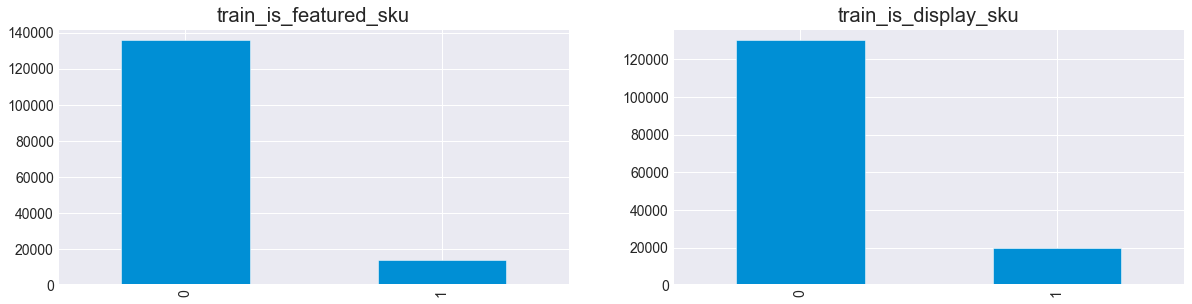

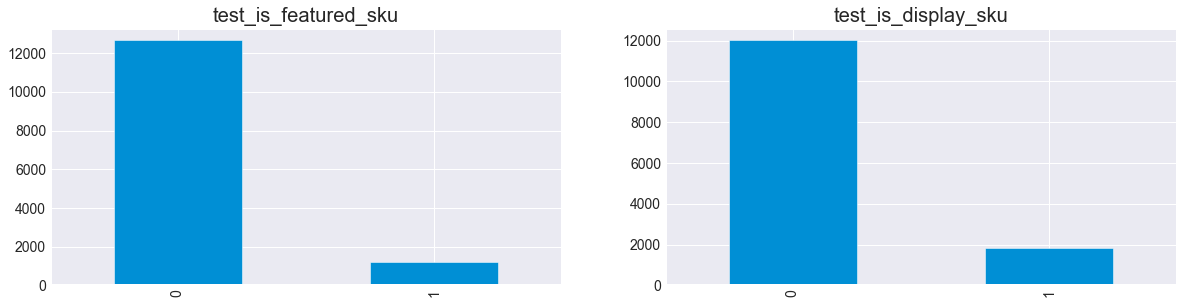

In [198]:
# Countplot of categorical variables
fig,ax = plt.subplots(1,2,figsize=(18,15))
i = 321
for f in ['is_featured_sku','is_display_sku']:
    plt.subplot(i)
    train_cat[f].value_counts().plot.bar(title = 'train_' + f)
    i += 1

fig,ax = plt.subplots(1,2,figsize=(18,15))
i = 321
for f in ['is_featured_sku','is_display_sku']:
    plt.subplot(i)
    test_cat[f].value_counts().plot.bar(title = 'test_' + f)
    i += 1

In [199]:
# Converting into numerical variables
train_cat['is_featured_sku']= train_cat['is_featured_sku'].astype('int64')
train_cat['is_display_sku']= train_cat['is_display_sku'].astype('int64')
test_cat['is_featured_sku']= test_cat['is_featured_sku'].astype('int64')
test_cat['is_display_sku']= test_cat['is_display_sku'].astype('int64')

In [200]:
# Feature encoding using one hot encoding of nominal categorical variables
store_tr_encoded= pd.get_dummies(train_cat['store_id'])
sku_tr_encoded= pd.get_dummies(train_cat['sku_id'])

store_te_encoded= pd.get_dummies(test_cat['store_id'])
sku_te_encoded= pd.get_dummies(test_cat['sku_id'])

In [201]:
# Finalising categorical dataframe
train_cat.drop(['store_id','sku_id','week'], axis=1, inplace= True)
test_cat.drop(['store_id','sku_id','week'], axis=1, inplace= True)

train_cat= pd.concat([train_cat,store_tr_encoded,sku_tr_encoded], axis=1)
test_cat= pd.concat([test_cat,store_te_encoded,sku_te_encoded], axis=1)

### EDA of numerical features

In [202]:
train_num = train[['total_price', 'base_price', 'units_sold']]
test_num = test[['total_price', 'base_price']]
display(train_num.head())
display(test_num.head())

,total_price,base_price,units_sold
0,99.0375,111.8625,20
1,99.0375,99.0375,28
2,133.9500,133.9500,19
3,133.9500,133.9500,44
4,141.0750,141.0750,52


,total_price,base_price
0,108.3000,108.3000
1,109.0125,109.0125
2,133.9500,133.9500
3,133.9500,133.9500
4,176.7000,176.7000


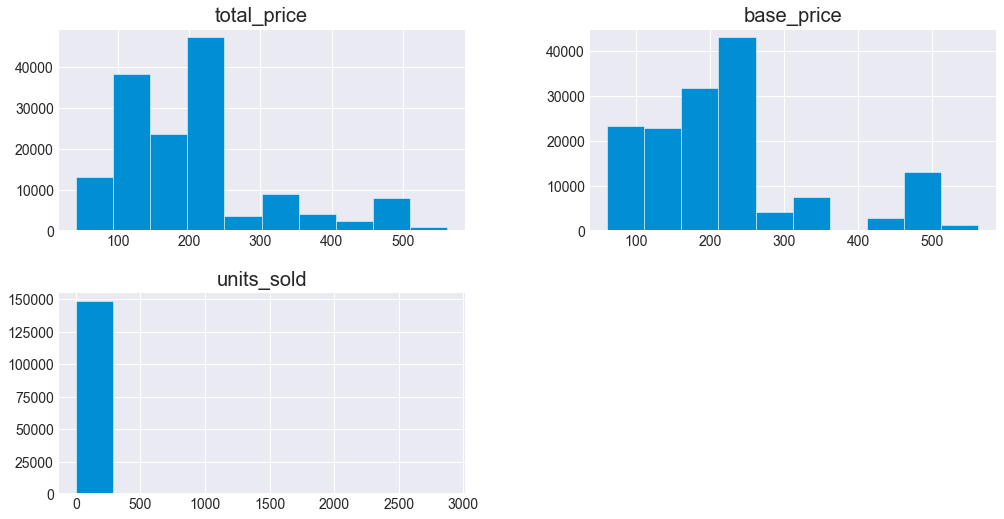

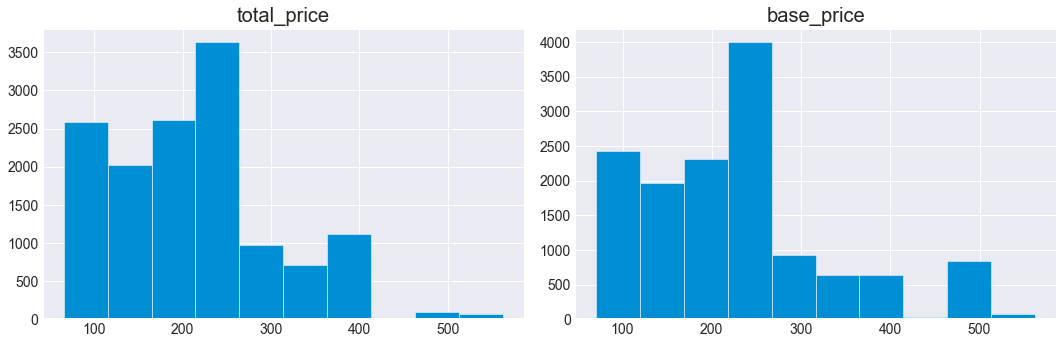

In [203]:
# Histplot of numerical variables
train_num.hist(figsize = (15,8))
test_num.hist(figsize = (15,5))
plt.tight_layout()
plt.show()

In [204]:
# Skewness will be treated in variable transformation part.

## Bivariate analysis

Text(0, 0.5, 'Units Sold')

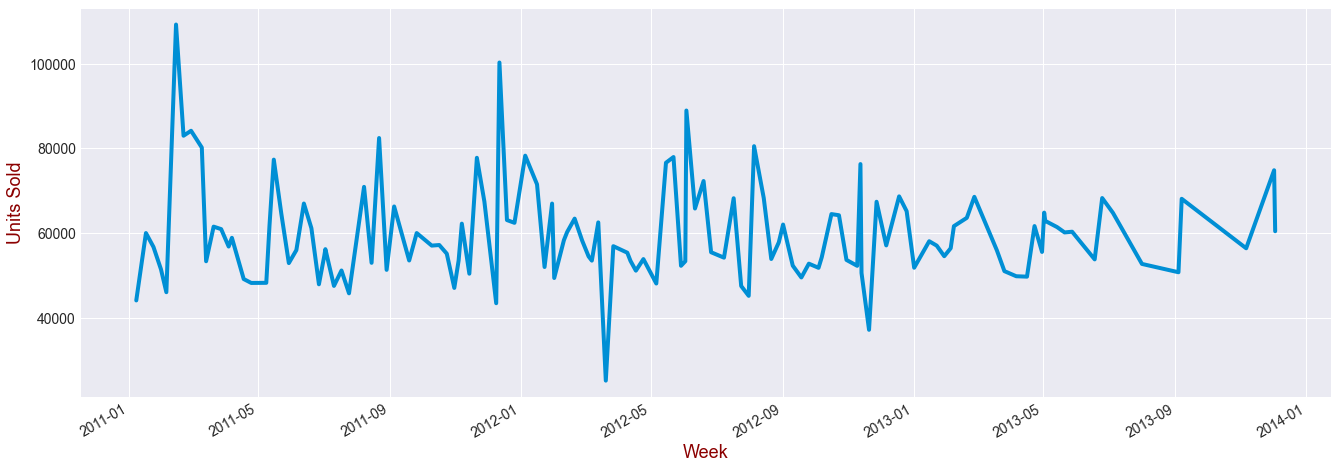

In [205]:
# Units sold plotted against week to understand trend if any
train['week']= pd.to_datetime(train['week'])
train.groupby('week').sum()['units_sold'].plot(figsize = (20,8))
plt.xlabel("Week", color= 'darkred', size= 18)
plt.ylabel("Units Sold", color= 'darkred', size= 18)

Text(0, 0.5, 'units_sold')

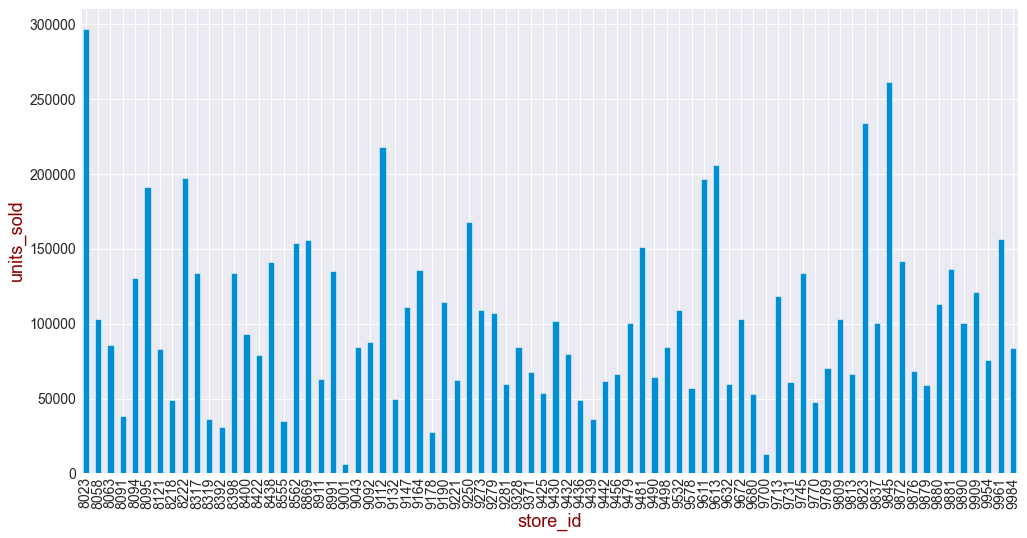

In [206]:
# units sold for each store id showing highest units sold for store id 8023
train.groupby('store_id').sum()['units_sold'].plot(figsize=(15,8),kind='bar')
plt.xlabel('store_id', color= 'darkred', size= 18)
plt.ylabel('units_sold', color= 'darkred', size= 18)

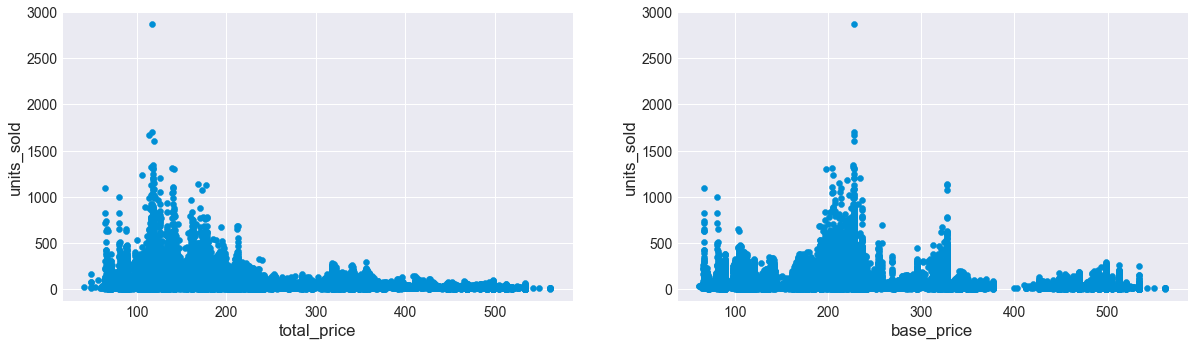

In [207]:
# scatter plot for units sold against total price and base price
fig,ax = plt.subplots(1,2,figsize=(18,5))
i = 121
for f in ['total_price', 'base_price']:
    plt.subplot(i)
    plt.scatter(train[f],train['units_sold'],label = f)
    plt.xlabel(f)
    plt.ylabel("units_sold")
    i += 1

### Missing value treatment

In [208]:
display(train.isna().sum())
display(test.isna().sum())

record_ID          0
week               0
store_id           0
sku_id             0
total_price        1
base_price         0
is_featured_sku    0
is_display_sku     0
units_sold         0
dtype: int64

record_ID          0
week               0
store_id           0
sku_id             0
total_price        0
base_price         0
is_featured_sku    0
is_display_sku     0
dtype: int64

In [209]:
# Only one entry for total_price is null in the train set. Replacing it with the base_price.
train_num['total_price'] = train_num['total_price'].fillna(train_num[train_num['total_price'].isnull()]['base_price'])

### Outlier treatment

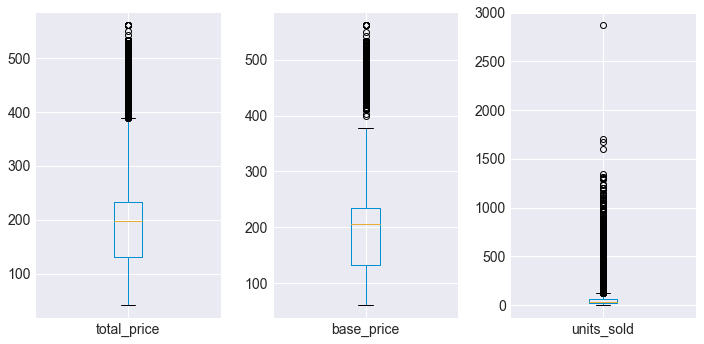

In [210]:
# High number of outliers seen for total price and base price
fig,axes=plt.subplots(1,3,figsize=(10,5))
for i,el in enumerate(list(train_num.columns.values)[:]):
    a = train_num.boxplot(el, ax=axes.flatten()[i]) 
plt.tight_layout() 
plt.show()

In [211]:
tp_90 = np.percentile(train_num['total_price'],90)
train_num.loc[train_num['total_price']> tp_90, ['total_price']] = tp_90

In [212]:
bp_90 = np.percentile(train_num['base_price'],90)
train_num.loc[train_num['base_price']> bp_90, ['base_price']] = bp_90

In [154]:
us_95 = np.percentile(train_num['units_sold'],95)
train_num.loc[train_num['units_sold']> us_95, ['units_sold']] = us_95

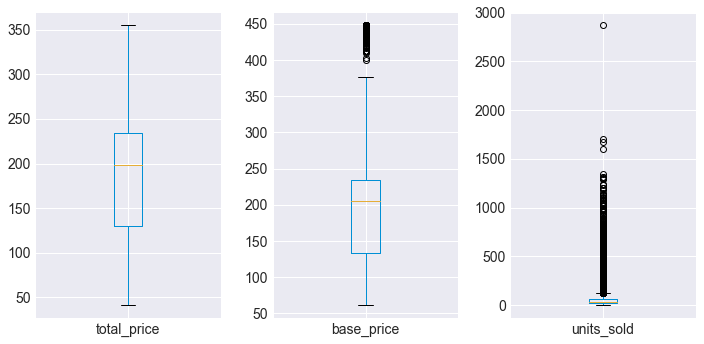

In [213]:
fig,axes=plt.subplots(1,3,figsize=(10,5))
for i,el in enumerate(list(train_num.columns.values)[:]):
    a = train_num.boxplot(el, ax=axes.flatten()[i]) 
plt.tight_layout() 
plt.show()

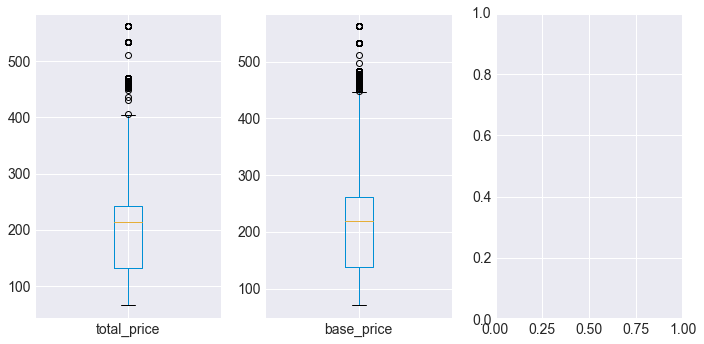

In [214]:
fig,axes=plt.subplots(1,3,figsize=(10,5))
for i,el in enumerate(list(test_num.columns.values)[:]):
    a= test_num.boxplot(el, ax=axes.flatten()[i]) 
plt.tight_layout() 
plt.show()

In [215]:
tp_95 = np.percentile(test_num['total_price'],95)
test_num.loc[test_num['total_price']> tp_95, ['total_price']] = tp_95

In [216]:
bp_92 = np.percentile(test_num['base_price'],92)
test_num.loc[test_num['base_price']> bp_92, ['base_price']] = bp_92

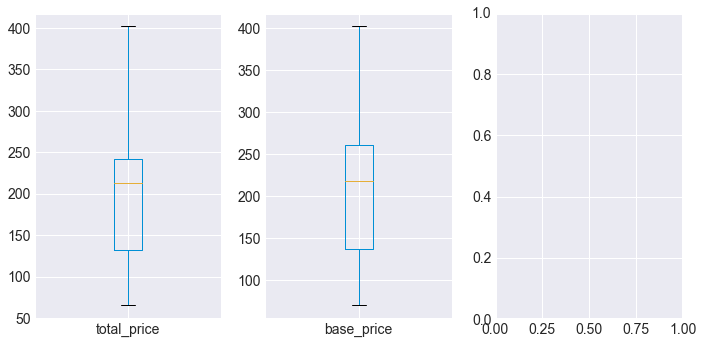

In [217]:
fig,axes=plt.subplots(1,3,figsize=(10,5))
for i,el in enumerate(list(test_num.columns.values)[:]):
    a= test_num.boxplot(el, ax=axes.flatten()[i]) 
plt.tight_layout() 
plt.show()

### Variable transformation & Normalisation

In [218]:
# units_sold, total_price, base_price are right distributed so trying log transformation
train_num['units_sold']= np.log(train_num['units_sold'])
train_num['total_price']= np.log(train_num['total_price'])
train_num['base_price']= np.log(train_num['base_price'])

test_num['base_price']= np.log(test_num['base_price'])
test_num['total_price']= np.log(test_num['total_price'])

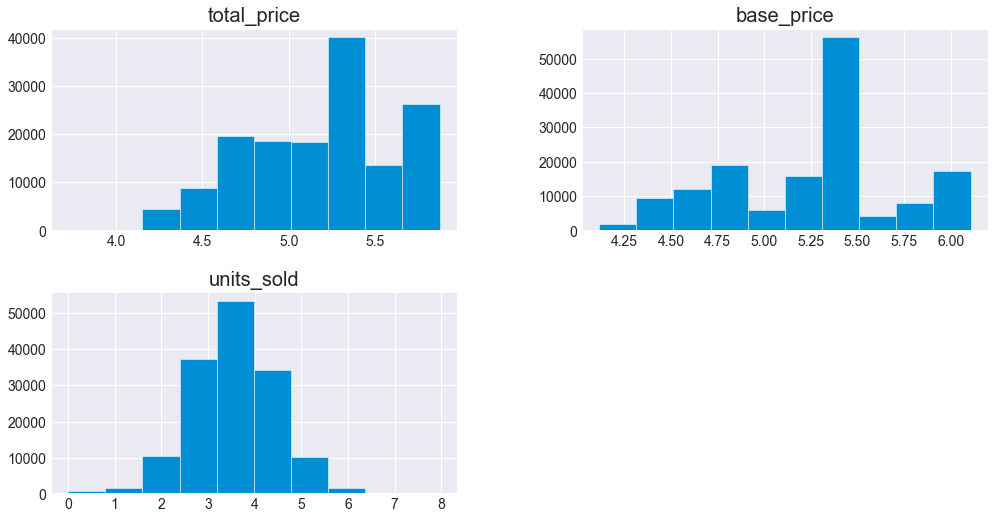

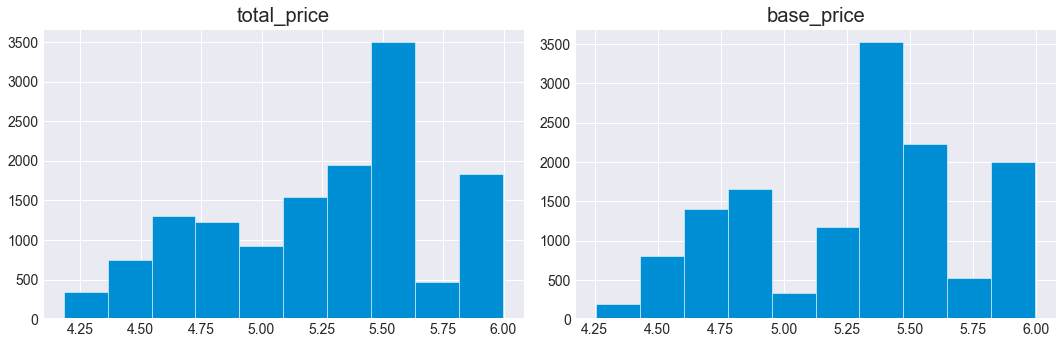

In [219]:
train_num.hist(figsize = (15,8))
test_num.hist(figsize = (15,5))
plt.tight_layout()
plt.show()

### Feature extraction

This step done after reviewing the performance of base model.

In [220]:
#Trying additional new features
# First is discount given on the products.
train_num['Discount'] = train_num['base_price'] - train_num['total_price']
test_num['Discount'] = test_num['base_price'] - test_num['total_price']
train_num['Discount']=np.where(train_num['Discount'] > 0 ,np.log(train_num['Discount']),0)
test_num['Discount']=np.where(test_num['Discount'] > 0 ,np.log(test_num['Discount']),0)

In [221]:
# Next feature is for products sold at premium price.
#train_num['Premium'] = train_num['total_price'] - train_num['base_price']
#test_num['Premium'] = test_num['total_price'] - test_num['base_price']
#train_num['Premium']=np.where(train_num['Premium'] > 0 ,np.log(train_num['Premium']),0)
#test_num['Premium']=np.where(test_num['Premium'] > 0 ,np.log(test_num['Premium']),0)
#Including Premium decreases adjusted R^2 by a small value so we will not include that in final analysis.

In [222]:
# Extracting time series features from week column
train['week']= pd.to_datetime(train['week'])
test['week']= pd.to_datetime(test['week'])
for i in (train, test):
    i['year']=i['week'].dt.year 
    i['month']=i['week'].dt.month
    i['week_number']=i['week'].dt.week

### Linear Regression assumption check

<AxesSubplot:>

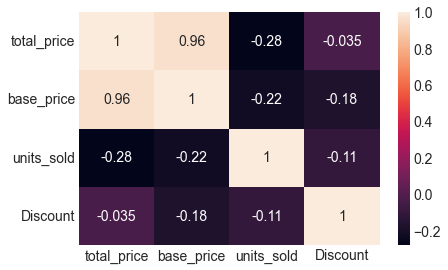

In [223]:
sns.heatmap(train_num.corr(),annot = True)

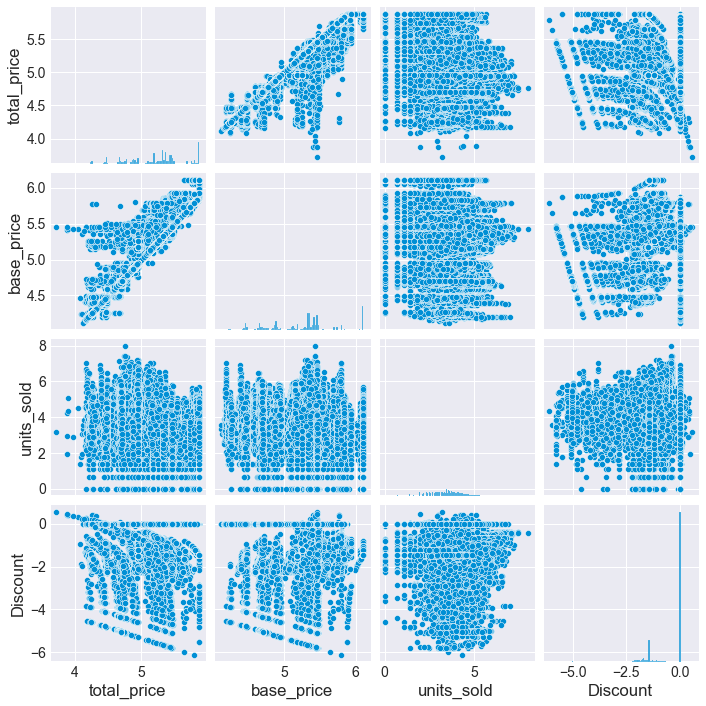

In [224]:
sns.pairplot(train_num)

<AxesSubplot:>

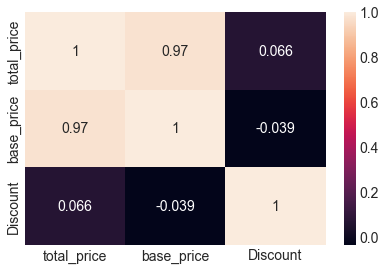

In [225]:
sns.heatmap(test_num.corr(),annot = True)

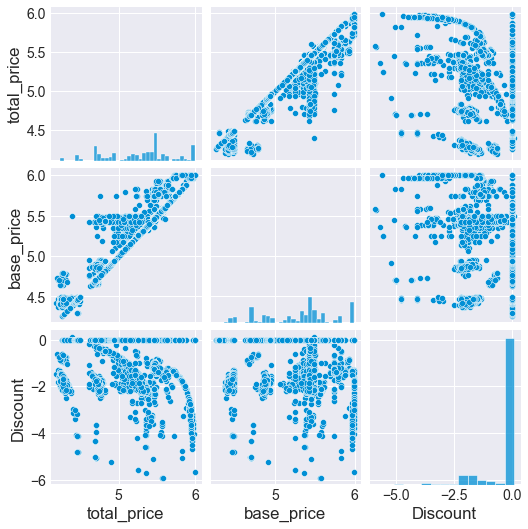

In [226]:
sns.pairplot(test_num)

In [227]:
vif_data_tr = pd.DataFrame()
vif_data_tr["feature"] = train_num.columns

vif_data_tr["VIF"] = [variance_inflation_factor(train_num.values, i)
                          for i in range(len(train_num.columns))]

print(vif_data_tr)

       feature          VIF
0  total_price  2298.100411
1   base_price  2346.026463
2   units_sold    12.982068
3     Discount     1.897918


In [228]:
# Dropping base price as it has very high vif score showing high multicollinearity
train_num.drop('base_price', axis= 1, inplace= True)
test_num.drop('base_price', axis= 1, inplace= True)

In [229]:
vif_data_tr = pd.DataFrame()
vif_data_tr["feature"] = train_num.columns

vif_data_tr["VIF"] = [variance_inflation_factor(train_num.values, i)
                          for i in range(len(train_num.columns))]

print(vif_data_tr)

       feature        VIF
0  total_price  12.812330
1   units_sold  12.916797
2     Discount   1.385483


In [230]:
# Finalising the datasets
train_final= pd.concat([train_num,train['year'],train['month'],train['week_number'],train_cat], axis=1)
test_final= pd.concat([test_num,test['year'],test['month'],test['week_number'],test_cat], axis=1)

### Model Implementation

In [231]:
X= train_final.drop('units_sold',axis=1)
y= train_final['units_sold']

In [232]:
train_final.describe()

,total_price,units_sold,Discount,year,month,week_number,is_featured_sku,is_display_sku,8023,8058,...,320485,327492,378934,398721,545621,546789,547934,600934,673209,679023
count,150150.000000,150150.000000,150150.000000,150150.000000,150150.000000,150150.000000,150150.000000,150150.000000,150150.000000,150150.000000,...,150150.000000,150150.000000,150150.000000,150150.000000,150150.000000,150150.000000,150150.000000,150150.000000,150150.000000,150150.000000
mean,5.195299,3.543324,-0.530797,2011.830769,6.130769,24.992308,0.095611,0.133200,0.018182,0.012987,...,0.037229,0.001732,0.030303,0.015584,0.000866,0.006061,0.026840,0.006061,0.001732,0.007792
std,0.432354,0.902000,0.875931,0.755887,3.438232,14.867927,0.294058,0.339792,0.133609,0.113219,...,0.189324,0.041577,0.171420,0.123861,0.029412,0.077614,0.161616,0.077614,0.041577,0.087929
min,3.721468,0.000000,-6.127960,2011.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.870511,2.995732,-1.383577,2011.000000,3.000000,12.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,5.288646,3.555348,0.000000,2012.000000,6.000000,23.500000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,5.454038,4.127134,0.000000,2012.000000,9.000000,38.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,5.873631,7.964156,0.551362,2013.000000,12.000000,52.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [233]:
X.head()

,total_price,Discount,year,month,week_number,is_featured_sku,is_display_sku,8023,8058,8063,...,320485,327492,378934,398721,545621,546789,547934,600934,673209,679023
0,4.595499,-2.105606,2011,1,3,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,4.595499,0.000000,2011,1,3,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4.897467,0.000000,2011,1,3,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4.897467,0.000000,2011,1,3,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4.949292,0.000000,2011,1,3,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [234]:
y.head()

0    2.995732
1    3.332205
2    2.944439
3    3.784190
4    3.951244
Name: units_sold, dtype: float64

In [235]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=10)

In [236]:
X_train.shape

(112612, 111)

In [237]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(X_train,y_train)

LinearRegression()

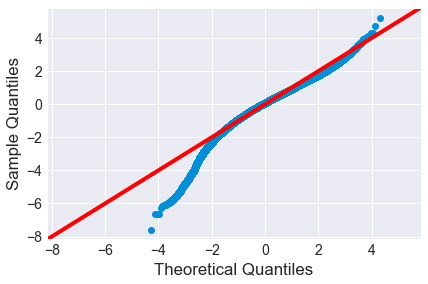

In [238]:
import statsmodels.api as sm
mod_fit = sm.OLS(y_train,X_train).fit()
res = mod_fit.resid
fig = sm.qqplot(res,fit=True,line='45')
plt.show()

In [239]:
model = sm.OLS(y_train,X_train)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:             units_sold   R-squared:                       0.613
Model:                            OLS   Adj. R-squared:                  0.612
Method:                 Least Squares   F-statistic:                     1632.
Date:                Sat, 06 Aug 2022   Prob (F-statistic):               0.00
Time:                        17:19:56   Log-Likelihood:                -94900.
No. Observations:              112612   AIC:                         1.900e+05
Df Residuals:                  112502   BIC:                         1.911e+05
Df Model:                         109                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
total_price        -1.0074      0.016    -

In [240]:
y_pred_tr=lr.predict(X_train)

In [241]:
y_pred=lr.predict(X_test)

In [242]:
lr.score(X_train, y_train)

0.6125295003181646

In [243]:
print(y_pred.min(),y_pred.max(),y_test.min(),y_test.max())

0.8920497894287109 6.682993412017822 0.0 7.166265974133638


<AxesSubplot:xlabel='units_sold', ylabel='Density'>

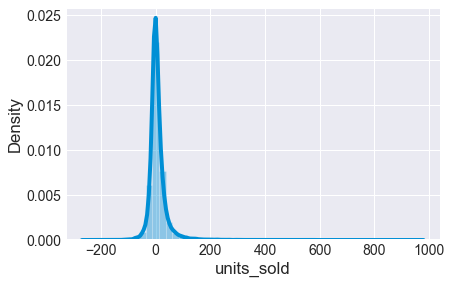

In [244]:
sns.distplot(np.exp(y_test)-np.exp(y_pred))

In [245]:
print('R^2:',metrics.r2_score(np.exp(y_test), np.exp(y_pred)))
print('Adjusted R^2:',1 - (1-metrics.r2_score(np.exp(y_test), np.exp(y_pred)))*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1))
#print('MAE:',metrics.mean_absolute_error(y_test, y_pred))
#print('MSE:',metrics.mean_squared_error(y_test, y_pred))
#print('RMSE:',np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('RMSLE:',100*np.sqrt(metrics.mean_squared_log_error(np.exp(y_test), np.exp(y_pred))))

R^2: 0.6121497832025719
Adjusted R^2: 0.6109994766225335
RMSLE: 53.224026908491865


### Metrics obtained for various iterations-
For base model we obtained metrics as-
R^2: 0.6117118131636503
Adjusted R^2: 0.6106018255603511
RMSLE: 53.32919637825183
which has high RMSLE. So feature extraction step is done after looking into base model performance.

After adding new feature of discount we got metrics as-
R^2: 0.6128726880829869
Adjusted R^2: 0.6117556464925881
RMSLE: 53.309964703354005

After adding new feature of premium we got metrics as-
R^2: 0.6114041006633838
Adjusted R^2: 0.6102724090681158
RMSLE: 53.343148020479134
This shows decrease in adjusted R^2 so we will not include this feature in our model.

After adding timeseries features, year,month & week we got metrics as-
R^2: 0.6121497832025719
Adjusted R^2: 0.6109994766225335
RMSLE: 53.224026908491865

In [250]:
test['units_sold']= np.round(np.exp(lr.predict(test_final)))

In [251]:
test['units_sold'].describe()

count    13860.000000
mean        40.745238
std         34.044492
min          4.000000
25%         20.000000
50%         32.000000
75%         50.000000
max        516.000000
Name: units_sold, dtype: float64

### Summary & Observations
=> There doesn't seem high linear correlation among independent variables and target variables.

=> Adding new features improved model accuracy and decreased RMSLE but not by very high values.

=> We can also see that linear regression assumptions were not satisfied in many cases.

=> So linear regression doesn't seem like good model.

=> Further we can use these results as base model and try ensemble techniques to improve the results further and get lower values of RMSLE.

## Light-GBM